# Online CNN training on a subspace using SMC

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
from functools import partial
from chex import ArrayDevice
from collections.abc import Callable
from tensorflow_probability.substrates import jax as tfp
from torchvision.datasets import MNIST
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

tfd = tfp.distributions

2022-09-08 08:44:09.208993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
jnp.set_printoptions(linewidth=200, suppress=True)

In [3]:
device_cpu, *_ = jax.devices("cpu")
device_tpu, *_ = jax.devices("tpu")

In [4]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [5]:
class MLP(nn.Module):
    n_hidden: int
    n_out: int
    activation: Callable[[ArrayDevice], ArrayDevice] = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
    
class SmallCNN(nn.Module):
    num_classes: int
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.tanh
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(6, kernel_size=(5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(120)(x)
        x = self.activation(x)
        x = nn.Dense(84)(x)
        x = self.activation(x)
        x = nn.Dense(self.num_classes)(x)
        # x = nn.log_softmax(x)
        return x


def smc_step(state, xs, reconstruct_fn, projection_matrix, dim_output, scale=0.1):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    ix_resample = jax.random.choice(key_resample, n_particles, p=weights, shape=(n_particles,))
    new_particles_cond = jax.tree_map(lambda x: x[ix_resample], particles_prev)
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=scale)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    logits = jax.vmap(model.apply, (0, None))(particles_full, xobs[None, ...])[:, 0, :]
    # logits = jax.vmap(model.apply, (0, None))(particles_full, xobs)
    dist_obs = tfd.Multinomial(dim_output, logits=logits)

    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "particles": particles_next,
        "log_target": distr_cond.log_prob(particles_next).sum(axis=1) + log_weights_next
    }
    
    return state_next, memory


def stratified_resampling(key, weights, particles):
    N = len(weights)
    u = (jnp.arange(N) + jax.random.uniform(key, (N,))) / N
    bins = jnp.cumsum(weights)
    return particles[jnp.digitize(u, bins)]


def smc_step_stratified(state, xs, reconstruct_fn, projection_matrix, dim_output, scale=0.1):
    (log_weights_prev, particles_prev) = state
    (key, xobs, yobs) = xs
    
    key_resample, key_propagate = jax.random.split(key)
    
    # 1. Resample particles
    weights = jnp.exp(log_weights_prev - jax.nn.logsumexp(log_weights_prev))
    new_particles_cond = stratified_resampling(key_resample, weights, particles_prev)
    
    # 2. Propagate particles:
    #    Sample new particles conditioned on resampled particles
    distr_cond = tfd.Normal(loc=new_particles_cond, scale=scale)
    particles_next = distr_cond.sample(seed=key_propagate)
    
    particles_full = jnp.einsum("pk,mk->pm", particles_next, projection_matrix)
    particles_full = jax.vmap(reconstruct_fn)(particles_full)
    
    # 3. Construct new weights
    logits = jax.vmap(model.apply, (0, None))(particles_full, xobs[None, ...])[:, 0, :]
    # logits = jax.vmap(model.apply, (0, None))(particles_full, xobs)
    dist_obs = tfd.Multinomial(dim_output, logits=logits)

    log_weights_next = dist_obs.log_prob(yobs)
    
    state_next = (log_weights_next, particles_next)
    
    memory = {
        "particles": particles_next,
        "log_target": distr_cond.log_prob(particles_next).sum(axis=1) + log_weights_next,
        "weights": weights,
    }
    
    return state_next, memory


In [6]:
key = jax.random.PRNGKey(314)
key_sample_obs, key_weights, key_particles_init, key_smc, key_dummy, key_pm = jax.random.split(key, 6)

### Create train / test dataset

In [7]:
n_obs = 1000
X_train = jnp.array(mnist_train.data)[:n_obs]
y_train = jnp.array(mnist_train.targets)[:n_obs]

num_train, *_ = X_train.shape
# "Gaussanised" MNIST
X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, 10)
num_samples = len(X_train)

X_train.shape

(1000, 28, 28, 1)

## Classifying on a projected subspace

In [8]:
pca = PCA(n_components=0.9)

X_train_proj = jax.device_put(X_train.reshape(-1, 28 ** 2), device_cpu)
X_train_proj = pca.fit_transform(X_train_proj)
X_train_proj = jax.device_put(X_train_proj, device_tpu)

n_features = pca.n_components_
n_features

76

In [9]:
%%time
n_particles = 1500

model = MLP(100, 10)
batch = jnp.ones((1, n_features))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

dim_full = len(params_all_flat)
dim_subspace = 500

# key_pm = jax.device_put(key_pm, device_cpu) # Move pmatrix to CPU if too big to fit in TPU
# proj_matrix = jax.random.bernoulli(key_pm, p=0.5, shape=(dim_full, dim_subspace)).astype(float)
proj_matrix = jax.random.normal(key_pm, shape=(dim_full, dim_subspace))

particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))
print(proj_matrix.shape)


keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, X_train_proj, y_ohe_train)
part_smc_step = partial(smc_step_stratified,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        dim_output=10,
                        scale=0.1)

(_, particles_final_sub), hist = jax.block_until_ready(jax.lax.scan(part_smc_step, init_state, xs))

(18810, 500)


CPU times: user 17.4 s, sys: 424 ms, total: 17.8 s
Wall time: 9.63 s


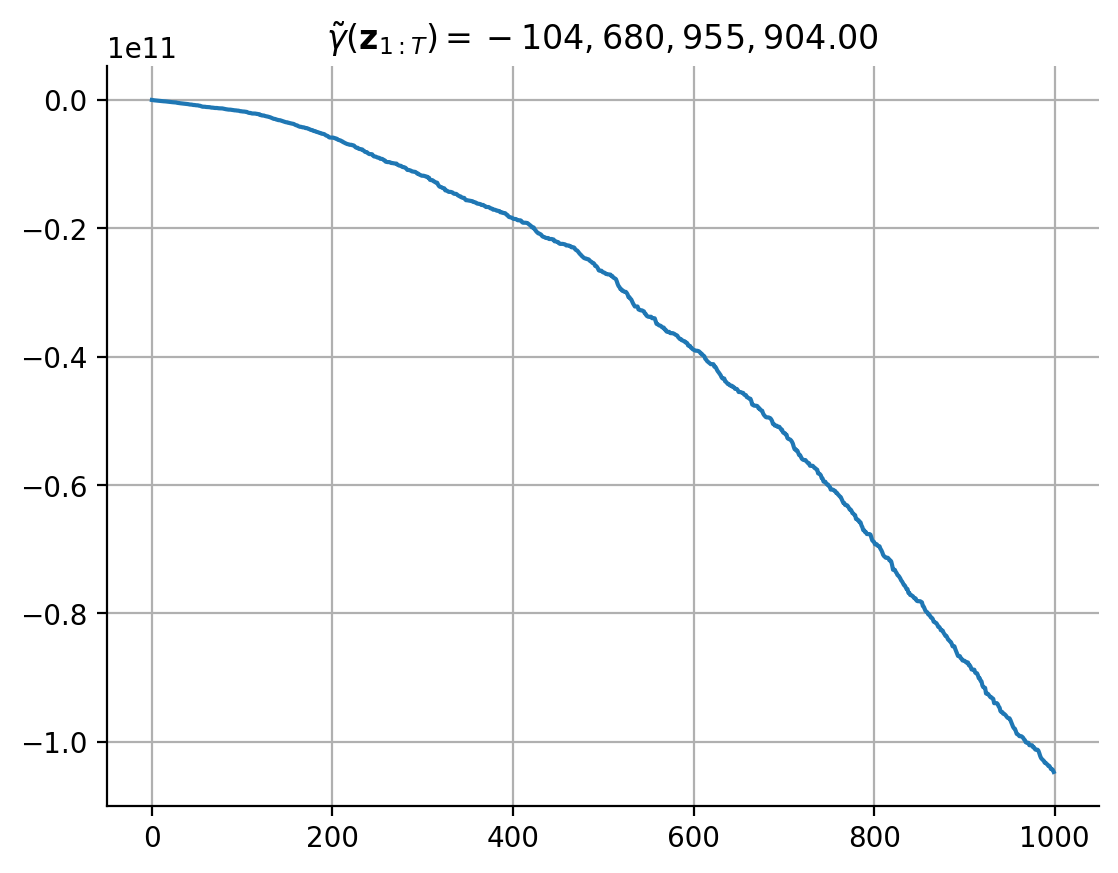

In [10]:
log_targets_hist = hist["log_target"]
# Log-unnormalised target distribution
log_utarget = log_targets_hist.sum(axis=0).mean()
plt.plot(log_targets_hist.cumsum(axis=0).mean(axis=1))
plt.title(r"$\tilde\gamma({\bf z}_{1:T})=" f"{log_utarget:,.2f}$")
plt.grid()

In [11]:
%%time 
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

particles_final = jax.device_put(particles_final, device_cpu)
X_train_cpu = jax.device_put(X_train_proj, device_cpu)

yhat_train = jax.vmap(model.apply, (0, None))(particles_final, X_train_cpu)
yhat_train = jax.nn.softmax(yhat_train)

CPU times: user 5.85 s, sys: 4.98 s, total: 10.8 s
Wall time: 2.34 s


In [54]:
yhat_train_argmax = yhat_train.mean(axis=0).argmax(axis=-1)
confusion_matrix(y_train, yhat_train_argmax)

array([[12,  1,  6,  2, 15, 31,  1, 21,  6,  2],
       [ 1, 31,  4, 27,  2,  8,  0,  4, 17, 22],
       [ 5,  7, 19, 20,  9,  8,  7, 11,  8,  5],
       [ 3,  8,  0, 25,  4,  6,  1,  5, 33,  8],
       [ 6,  1,  5, 11, 28, 23,  1,  1, 16, 13],
       [ 4,  9,  6,  7, 19,  9,  3,  1, 24, 10],
       [ 5,  8,  7, 14, 32, 12,  8,  2,  1,  5],
       [ 3,  1,  7,  0, 15, 12,  0, 70,  1,  8],
       [ 3,  0,  9, 15,  4,  8,  3,  1, 35,  9],
       [ 6,  3,  0,  1, 26, 11,  0, 11,  8, 34]])

In [55]:
(yhat_train_argmax == y_train).mean()

DeviceArray(0.27100003, dtype=float32)

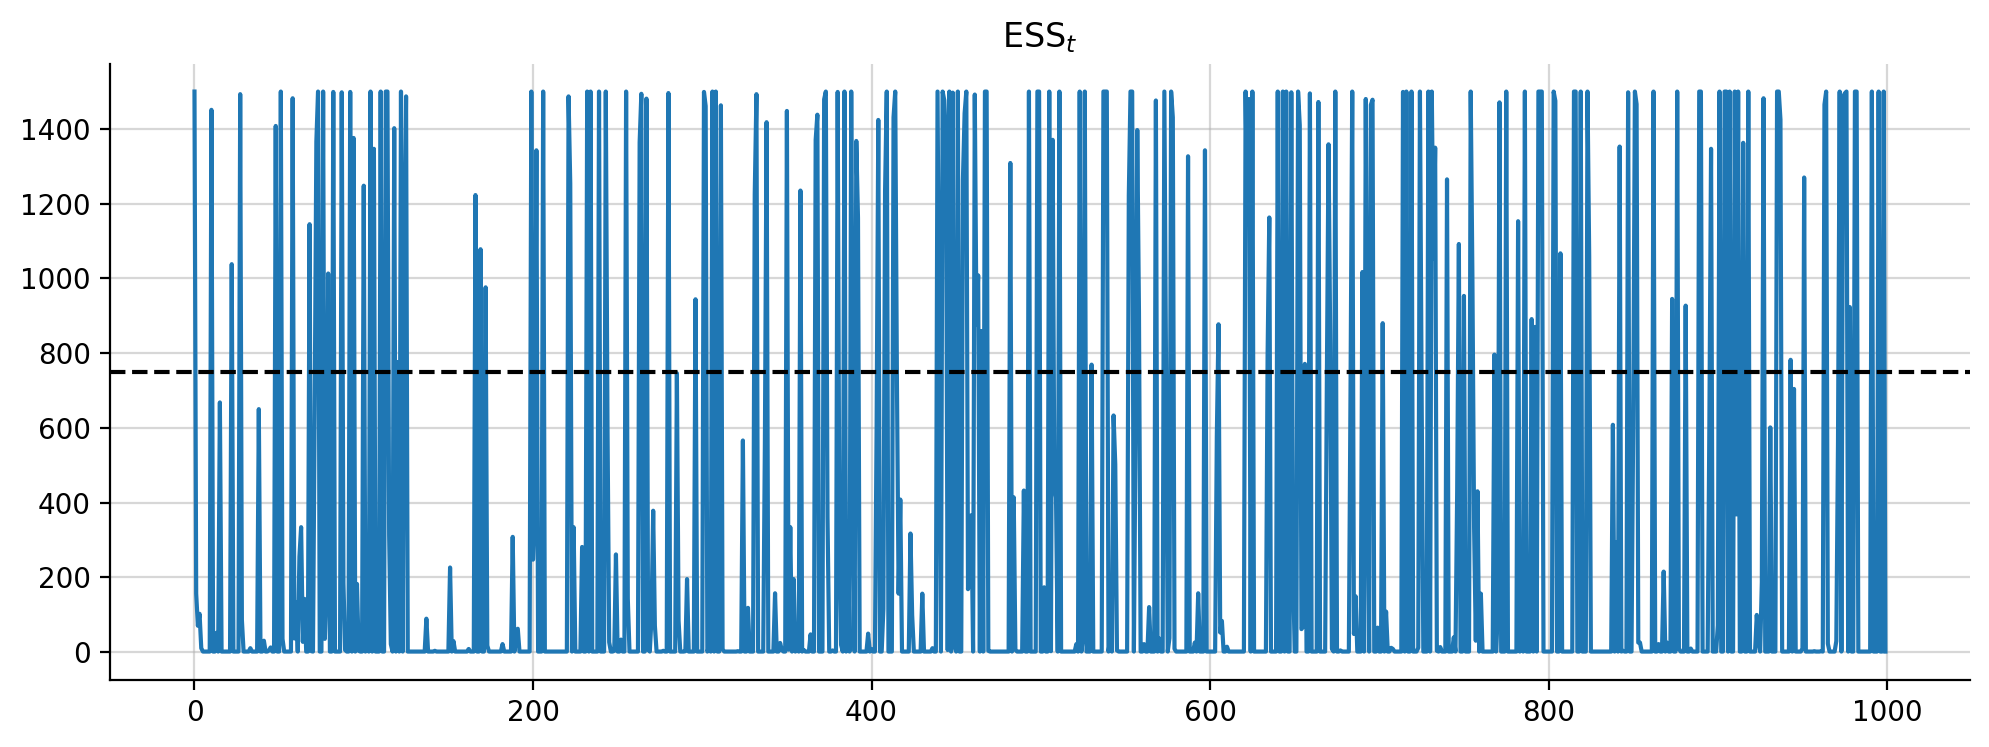

In [53]:
# Effective sample size
ess_hist = 1 / (hist["weights"] ** 2).sum(axis=-1)

fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(ess_hist)
plt.grid(alpha=0.5)
plt.axhline(y=n_particles / 2, c="black", linestyle="--")
plt.title(r"ESS$_t$");

## Classification on a $28^2$-dimensional space

In [42]:
n_particles = 1500
dim_subspace = 2000

model = SmallCNN(10)
batch = jnp.ones((1, 28, 28, 1))
params_all = model.init(key_dummy, batch)
params_all_flat, params_reconstruct_fn = ravel_pytree(params_all)

In [43]:
dim_full = len(params_all_flat)

key_pm = jax.device_put(key_pm, device_cpu) # Move pmatrix to CPU if too big to fit in TPU
proj_matrix = jax.random.normal(key_pm, shape=(dim_full, dim_subspace))

particles_init = jax.random.normal(key_particles_init, (n_particles, dim_subspace))
log_weights_init = jnp.zeros((n_particles,))

proj_matrix.shape

(152410, 2000)

In [ ]:
%%time
keys_smc = jax.random.split(key_smc, n_obs)

init_state = (log_weights_init, particles_init)
xs = (keys_smc, X_train, y_ohe_train)
part_smc_step = partial(smc_step_stratified,
                        reconstruct_fn=params_reconstruct_fn,
                        projection_matrix=proj_matrix,
                        dim_output=10)

(_, particles_final_sub), hist = jax.block_until_ready(jax.lax.scan(part_smc_step, init_state, xs))

tcmalloc: large alloc 12000002048 bytes == 0x55e540814000 @  0x7f9937ea2680 0x7f9937ec3824 0x7f9937ec3b8a 0x7f992d4bcff4 0x7f99295bd92f 0x7f99295c930c 0x7f99295cc9e5 0x7f992951637a 0x7f9929270f68 0x7f992925500b 0x55dd16246fc9 0x55dd16267e5b 0x55dd162a2c07 0x55dd162e688c 0x55dd16232ac8 0x55dd162a2016 0x55dd162685d9 0x55dd16180781 0x55dd16246e0b 0x55dd162e4906 0x55dd162321e6 0x55dd162a2016 0x55dd162685d9 0x55dd16354030 0x55dd16246db5 0x55dd162e4906 0x55dd162a1e62 0x55dd162e23ab 0x55dd162a1e62 0x55dd162e23ab 0x55dd162321e6


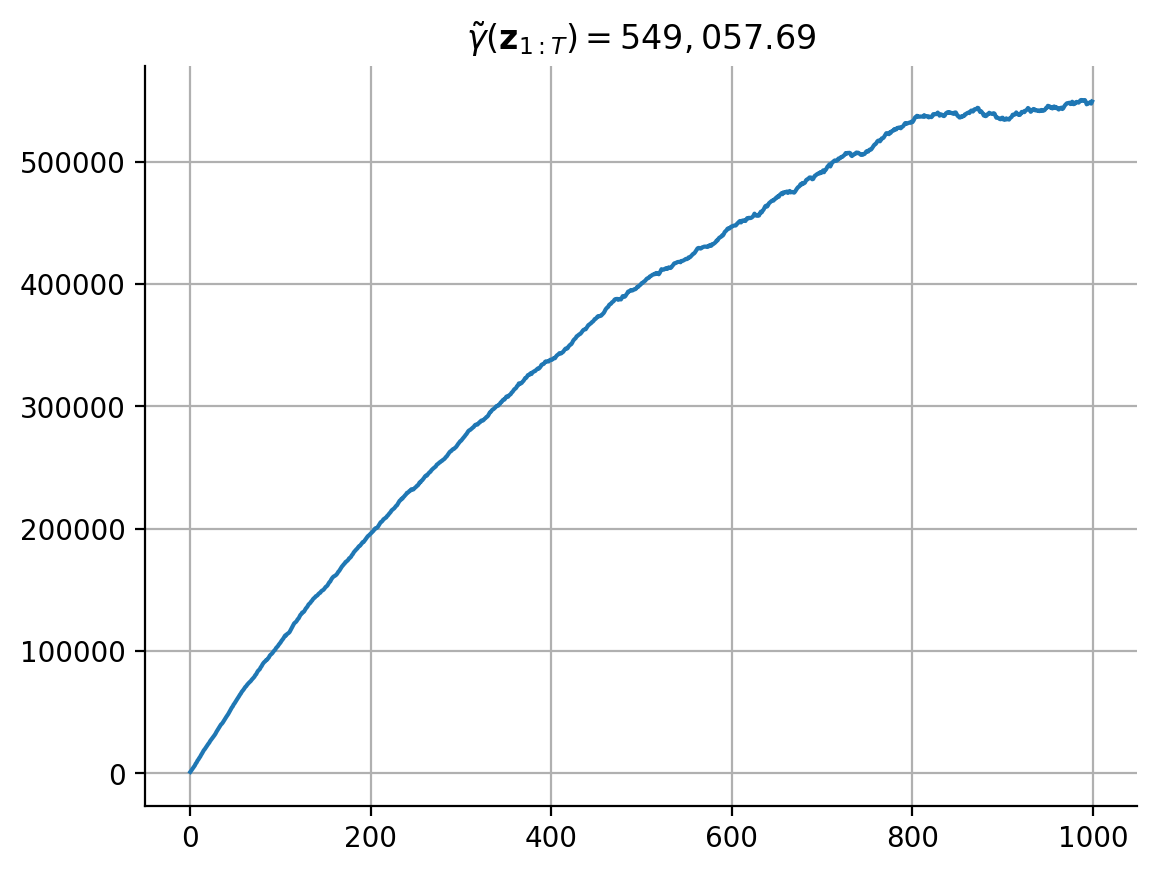

In [57]:
log_targets_hist = hist["log_target"]

# Log-unnormalised target distribution
log_utarget = log_targets_hist.sum(axis=0).mean()
plt.plot(log_targets_hist.cumsum(axis=0).mean(axis=1))
plt.title(r"$\tilde\gamma({\bf z}_{1:T})=" f"{log_utarget:,.2f}$")
plt.grid()

In [53]:
%%time 
particles_final = jnp.einsum("pk,mk->pm", particles_final_sub, proj_matrix)
particles_final = jax.vmap(params_reconstruct_fn)(particles_final)

particles_final = jax.device_put(particles_final, device_cpu)
X_train_cpu = jax.device_put(X_train, device_cpu)

yhat_train = jax.vmap(model.apply, (0, None))(particles_final, X_train_cpu[:500])
yhat_train = jax.nn.softmax(yhat_train)

tcmalloc: large alloc 14112006144 bytes == 0x55e14e22a000 @  0x7f9937ea2680 0x7f9937ec3824 0x7f9937ec3b8a 0x7f992d4bcff4 0x7f99295bd92f 0x7f99295c930c 0x7f99295cc9e5 0x7f992951637a 0x7f9929270f68 0x7f992925500b 0x55dd16246fc9 0x55dd16267e5b 0x55dd162a2c07 0x55dd162e688c 0x55dd16232ac8 0x55dd162a2016 0x55dd162685d9 0x55dd16180781 0x55dd16246e0b 0x55dd162e4906 0x55dd162321e6 0x55dd162a2016 0x55dd16246e0b 0x55dd162e4906 0x55dd162321e6 0x55dd162a2016 0x55dd162685d9 0x55dd16354030 0x55dd16246db5 0x55dd162e4906 0x55dd162a1e62
tcmalloc: large alloc 14112006144 bytes == 0x55e88a256000 @  0x7f9937ea2680 0x7f9937ec3824 0x7f9929d2bee5 0x7f9929db348b 0x7f9929db3af9 0x7f96f7fe90a3 0x7f99295cc9e5 0x7f992951637a 0x7f9929270f68 0x7f992925500b 0x55dd16246fc9 0x55dd16267e5b 0x55dd162a2c07 0x55dd162e688c 0x55dd16232ac8 0x55dd162a2016 0x55dd162685d9 0x55dd16180781 0x55dd16246e0b 0x55dd162e4906 0x55dd162321e6 0x55dd162a2016 0x55dd16246e0b 0x55dd162e4906 0x55dd162321e6 0x55dd162a2016 0x55dd162685d9 0x55dd16

CPU times: user 2min 44s, sys: 1min 17s, total: 4min 2s
Wall time: 12.5 s


In [54]:
yhat_train_argmax = yhat_train.mean(axis=0).argmax(axis=-1)
confusion_matrix(y_train[:500], yhat_train_argmax)

array([[ 0,  4, 12,  0,  0,  7, 11,  7,  0,  9],
       [ 1,  2, 23,  6,  3,  7,  1,  8,  1, 14],
       [ 3,  9,  8,  0,  0,  1,  5, 23,  1,  2],
       [ 2, 12, 10,  0,  2,  0,  4, 14,  2,  4],
       [ 1,  1,  3,  2,  6,  2,  8, 29,  0,  0],
       [ 8,  1, 10,  0,  1,  7,  4,  6,  0,  2],
       [ 1,  1,  3,  1,  1,  2, 18, 14,  1,  3],
       [ 4,  0, 12,  1,  1,  3,  4, 24,  1,  2],
       [ 2,  0,  2,  0,  0,  9,  2, 16,  5,  3],
       [ 1,  0,  7,  1,  3,  6,  2, 33,  0,  2]])

In [55]:
(yhat_train_argmax == y_train[:500]).mean()

DeviceArray(0.14400001, dtype=float32)

In [36]:
(yhat_train_argmax == y_train[:500]).mean()

DeviceArray(0.15400001, dtype=float32)